In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.disable_eager_execution()
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
df = pd.read_csv('dataset/GOOG.csv')
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-08-12,242.212219,247.622620,241.496490,246.251251,246.251251,4404700
1,2010-08-13,244.744751,245.840836,243.248245,243.418411,243.418411,3865500
2,2010-08-16,242.082077,245.180176,240.490494,243.038040,243.038040,2607300
3,2010-08-17,244.509506,247.597595,243.258255,245.505508,245.505508,3777600
4,2010-08-18,245.465469,245.680679,241.016022,241.316315,241.316315,5367400


In [3]:
minmax = MinMaxScaler().fit(df.iloc[:, 1:].astype('float32'))
df_log = minmax.transform(df.iloc[:, 1:].astype('float32'))
df_log = pd.DataFrame(df_log)
df_log.head()

,0,1,2,3,4,5
0,0.021771,0.025559,0.022584,0.026977,0.026977,0.133477
1,0.025017,0.023277,0.024851,0.023340,0.023340,0.114948
2,0.021604,0.022431,0.021281,0.022852,0.022852,0.071710
3,0.024715,0.025527,0.024864,0.026019,0.026019,0.111927
4,0.025940,0.023072,0.021962,0.020642,0.020642,0.166561


In [4]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 700
dropout_rate = 0.7
future_day = 50

In [5]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
        attention_size = 10,
    ):
        def lstm_cell():
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        backward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell() for _ in range(num_layers)], state_is_tuple = False
        )
        forward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell() for _ in range(num_layers)], state_is_tuple = False
        )
        self.X = tf.placeholder(tf.float32, [None, None, size])
        self.Y = tf.placeholder(tf.float32, [None, output_size])
        drop_backward = tf.nn.rnn_cell.DropoutWrapper(
            backward_rnn_cells, output_keep_prob = forget_bias
        )
        drop_forward = tf.nn.rnn_cell.DropoutWrapper(
            forward_rnn_cells, output_keep_prob = forget_bias
        )
        self.backward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * 2 * size_layer)
        )
        self.forward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * 2 * size_layer)
        )
        outputs, last_state = tf.nn.bidirectional_dynamic_rnn(
            drop_forward,
            drop_backward,
            self.X,
            initial_state_fw = self.forward_hidden_layer,
            initial_state_bw = self.backward_hidden_layer,
            dtype = tf.float32,
        )
        outputs = list(outputs)
        attention_w = tf.get_variable(
            'attention_v1', [attention_size], tf.float32
        )
        query = tf.layers.dense(
            tf.expand_dims(last_state[0][:, size_layer:], 1), attention_size
        )
        keys = tf.layers.dense(outputs[0], attention_size)
        align = tf.reduce_sum(attention_w * tf.tanh(keys + query), [2])
        align = tf.nn.tanh(align)
        outputs[0] = tf.squeeze(
            tf.matmul(
                tf.transpose(outputs[0], [0, 2, 1]), tf.expand_dims(align, 2)
            ),
            2,
        )
        outputs[0] = tf.concat([outputs[0], last_state[0][:, size_layer:]], 1)

        attention_w = tf.get_variable(
            'attention_v2', [attention_size], tf.float32
        )
        query = tf.layers.dense(
            tf.expand_dims(last_state[1][:, size_layer:], 1), attention_size
        )
        keys = tf.layers.dense(outputs[1], attention_size)
        align = tf.reduce_sum(attention_w * tf.tanh(keys + query), [2])
        align = tf.nn.tanh(align)
        outputs[1] = tf.squeeze(
            tf.matmul(
                tf.transpose(outputs[1], [0, 2, 1]), tf.expand_dims(align, 2)
            ),
            2,
        )
        outputs[1] = tf.concat([outputs[1], last_state[1][:, size_layer:]], 1)

        with tf.variable_scope('decoder', reuse = False):
            self.backward_rnn_cells_dec = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell() for _ in range(num_layers)], state_is_tuple = False
            )
            self.forward_rnn_cells_dec = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell() for _ in range(num_layers)], state_is_tuple = False
            )
            backward_drop_dec = tf.nn.rnn_cell.DropoutWrapper(
                self.backward_rnn_cells_dec, output_keep_prob = forget_bias
            )
            forward_drop_dec = tf.nn.rnn_cell.DropoutWrapper(
                self.forward_rnn_cells_dec, output_keep_prob = forget_bias
            )
            self.outputs, self.last_state = tf.nn.bidirectional_dynamic_rnn(
                forward_drop_dec,
                backward_drop_dec,
                self.X,
                initial_state_fw = outputs[0],
                initial_state_bw = outputs[1],
                dtype = tf.float32,
            )
        self.outputs = list(self.outputs)
        attention_w = tf.get_variable(
            'attention_v3', [attention_size], tf.float32
        )
        query = tf.layers.dense(
            tf.expand_dims(self.last_state[0][:, size_layer:], 1),
            attention_size,
        )
        keys = tf.layers.dense(self.outputs[0], attention_size)
        align = tf.reduce_sum(attention_w * tf.tanh(keys + query), [2])
        align = tf.nn.tanh(align)
        self.outputs[0] = tf.squeeze(
            tf.matmul(
                tf.transpose(self.outputs[0], [0, 2, 1]),
                tf.expand_dims(align, 2),
            ),
            2,
        )

        attention_w = tf.get_variable(
            'attention_v4', [attention_size], tf.float32
        )
        query = tf.layers.dense(
            tf.expand_dims(self.last_state[1][:, size_layer:], 1),
            attention_size,
        )
        keys = tf.layers.dense(self.outputs[1], attention_size)
        align = tf.reduce_sum(attention_w * tf.tanh(keys + query), [2])
        align = tf.nn.tanh(align)
        self.outputs[1] = tf.squeeze(
            tf.matmul(
                tf.transpose(self.outputs[1], [0, 2, 1]),
                tf.expand_dims(align, 2),
            ),
            2,
        )
        self.outputs = tf.concat(self.outputs, 1)
        self.logits = tf.layers.dense(self.outputs, output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate = learning_rate
        ).minimize(self.cost)


In [6]:
tf.reset_default_graph()
modelnn = Model(0.01, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


In [7]:
for i in range(epoch):
    init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
    init_value_backward = np.zeros((1, num_layers * 2 * size_layer))
    total_loss = 0
    for k in range(0, (df_log.shape[0] // timestamp) * timestamp, timestamp):
        batch_x = np.expand_dims(
            df_log.iloc[k : k + timestamp].values, axis = 0
        )
        batch_y = df_log.iloc[k + 1 : k + timestamp + 1].values
        last_state, _, loss = sess.run(
            [modelnn.last_state, modelnn.optimizer, modelnn.cost],
            feed_dict = {
                modelnn.X: batch_x,
                modelnn.Y: batch_y,
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        loss = np.mean(loss)
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        total_loss += loss
    total_loss /= df_log.shape[0] // timestamp
    print('epoch:', i + 1, 'avg loss:', total_loss)

epoch: 1 avg loss: 0.0027129643384465785


In [8]:
output_predict = np.zeros((df_log.shape[0] + future_day, df_log.shape[1]))
output_predict[0] = df_log.iloc[0]
upper_b = (df_log.shape[0] // timestamp) * timestamp
init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
init_value_backward = np.zeros((1, num_layers * 2 * size_layer))
for k in range(0, (df_log.shape[0] // timestamp) * timestamp, timestamp):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(df_log.iloc[k : k + timestamp], axis = 0),
            modelnn.backward_hidden_layer: init_value_backward,
            modelnn.forward_hidden_layer: init_value_forward,
        },
    )
    init_value_forward = last_state[0]
    init_value_backward = last_state[1]
    output_predict[k + 1 : k + timestamp + 1] = out_logits

out_logits, last_state = sess.run(
    [modelnn.logits, modelnn.last_state],
    feed_dict = {
        modelnn.X: np.expand_dims(df_log.iloc[upper_b:], axis = 0),
        modelnn.backward_hidden_layer: init_value_backward,
        modelnn.forward_hidden_layer: init_value_forward,
    },
)
init_value_forward = last_state[0]
init_value_backward = last_state[1]
output_predict[upper_b + 1 : df_log.shape[0] + 1] = out_logits
df_log.loc[df_log.shape[0]] = out_logits[-1]
date_ori.append(date_ori[-1] + timedelta(days = 1))

In [9]:
for i in range(future_day - 1):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(df_log.iloc[-timestamp:], axis = 0),
            modelnn.backward_hidden_layer: init_value_backward,
            modelnn.forward_hidden_layer: init_value_forward,
        },
    )
    init_value_forward = last_state[0]
    init_value_backward = last_state[1]
    output_predict[df_log.shape[0]] = out_logits[-1]
    df_log.loc[df_log.shape[0]] = out_logits[-1]
    date_ori.append(date_ori[-1] + timedelta(days = 1))

In [10]:
df_log = minmax.inverse_transform(output_predict)
date_ori = pd.Series(date_ori).dt.strftime(date_format = '%Y-%m-%d').tolist()

print(df_log.shape)
print(df.shape)

(1811, 6)
(1761, 7)


In [11]:
def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

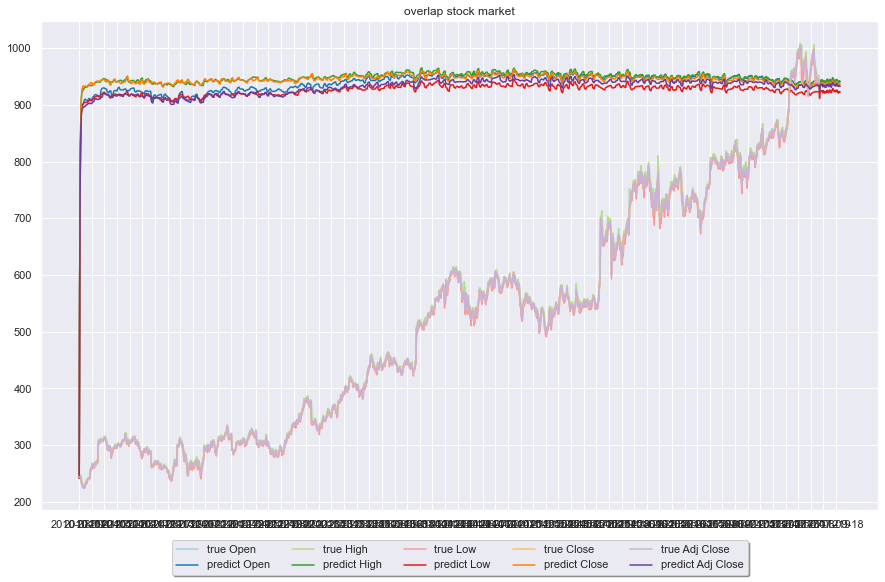

In [12]:
current_palette = sns.color_palette('Paired', 12)
fig = plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
x_range_original = np.arange(df.shape[0])
x_range_future = np.arange(df_log.shape[0])
ax.plot(
    x_range_original,
    df.iloc[:, 1],
    label = 'true Open',
    color = current_palette[0],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 0], 0.5),
    label = 'predict Open',
    color = current_palette[1],
)
ax.plot(
    x_range_original,
    df.iloc[:, 2],
    label = 'true High',
    color = current_palette[2],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 1], 0.5),
    label = 'predict High',
    color = current_palette[3],
)
ax.plot(
    x_range_original,
    df.iloc[:, 3],
    label = 'true Low',
    color = current_palette[4],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 2], 0.5),
    label = 'predict Low',
    color = current_palette[5],
)
ax.plot(
    x_range_original,
    df.iloc[:, 4],
    label = 'true Close',
    color = current_palette[6],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 3], 0.5),
    label = 'predict Close',
    color = current_palette[7],
)
ax.plot(
    x_range_original,
    df.iloc[:, 5],
    label = 'true Adj Close',
    color = current_palette[8],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 4], 0.5),
    label = 'predict Adj Close',
    color = current_palette[9],
)
box = ax.get_position()
ax.set_position(
    [box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9]
)
ax.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.title('overlap stock market')
plt.xticks(x_range_future[::30], date_ori[::30])
plt.show()

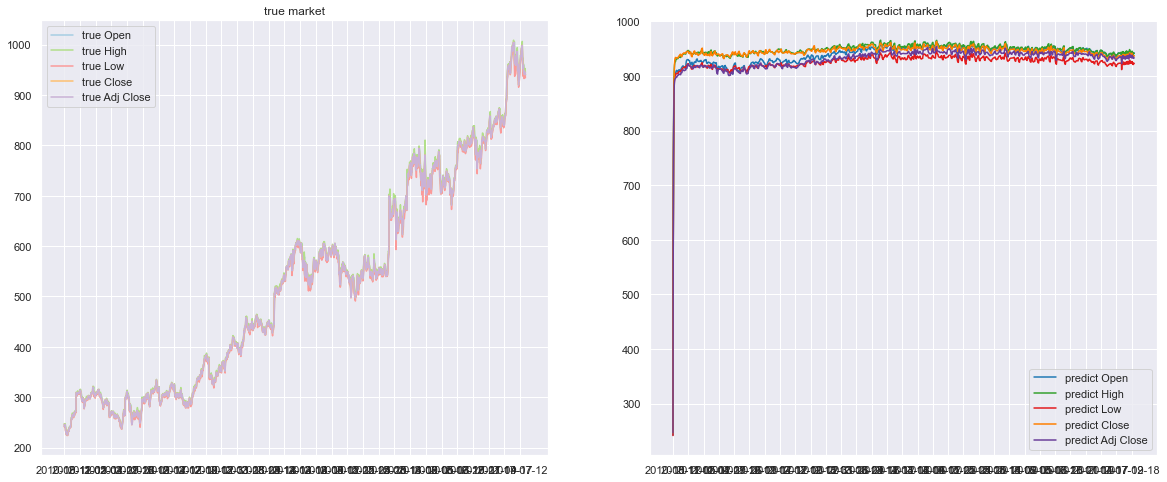

In [13]:
fig = plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(
    x_range_original,
    df.iloc[:, 1],
    label = 'true Open',
    color = current_palette[0],
)
plt.plot(
    x_range_original,
    df.iloc[:, 2],
    label = 'true High',
    color = current_palette[2],
)
plt.plot(
    x_range_original,
    df.iloc[:, 3],
    label = 'true Low',
    color = current_palette[4],
)
plt.plot(
    x_range_original,
    df.iloc[:, 4],
    label = 'true Close',
    color = current_palette[6],
)
plt.plot(
    x_range_original,
    df.iloc[:, 5],
    label = 'true Adj Close',
    color = current_palette[8],
)
plt.xticks(x_range_original[::60], df.iloc[:, 0].tolist()[::60])
plt.legend()
plt.title('true market')
plt.subplot(1, 2, 2)
plt.plot(
    x_range_future,
    anchor(df_log[:, 0], 0.5),
    label = 'predict Open',
    color = current_palette[1],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 1], 0.5),
    label = 'predict High',
    color = current_palette[3],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 2], 0.5),
    label = 'predict Low',
    color = current_palette[5],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 3], 0.5),
    label = 'predict Close',
    color = current_palette[7],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 4], 0.5),
    label = 'predict Adj Close',
    color = current_palette[9],
)
plt.xticks(x_range_future[::60], date_ori[::60])
plt.legend()
plt.title('predict market')
plt.show()

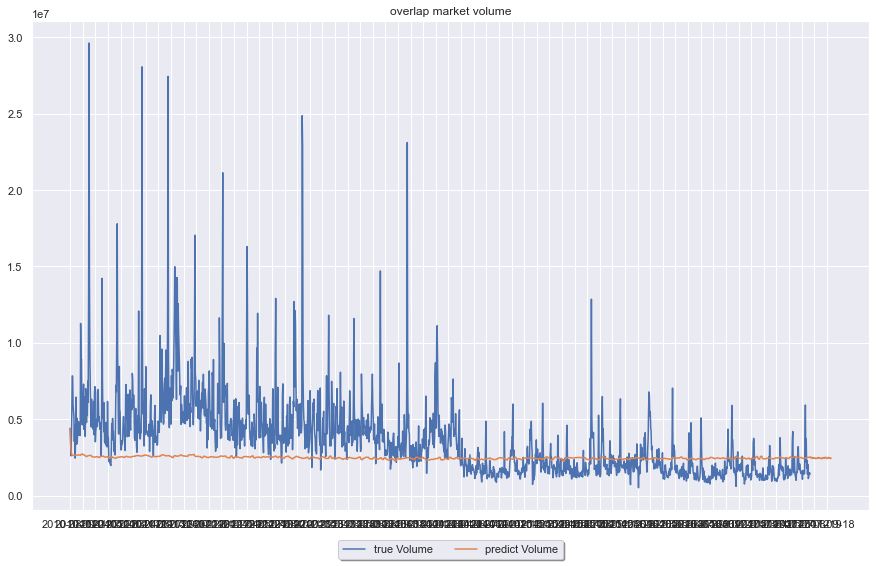

In [14]:
fig = plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
ax.plot(x_range_original, df.iloc[:, -1], label = 'true Volume')
ax.plot(x_range_future, anchor(df_log[:, -1], 0.5), label = 'predict Volume')
box = ax.get_position()
ax.set_position(
    [box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9]
)
ax.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.xticks(x_range_future[::30], date_ori[::30])
plt.title('overlap market volume')
plt.show()

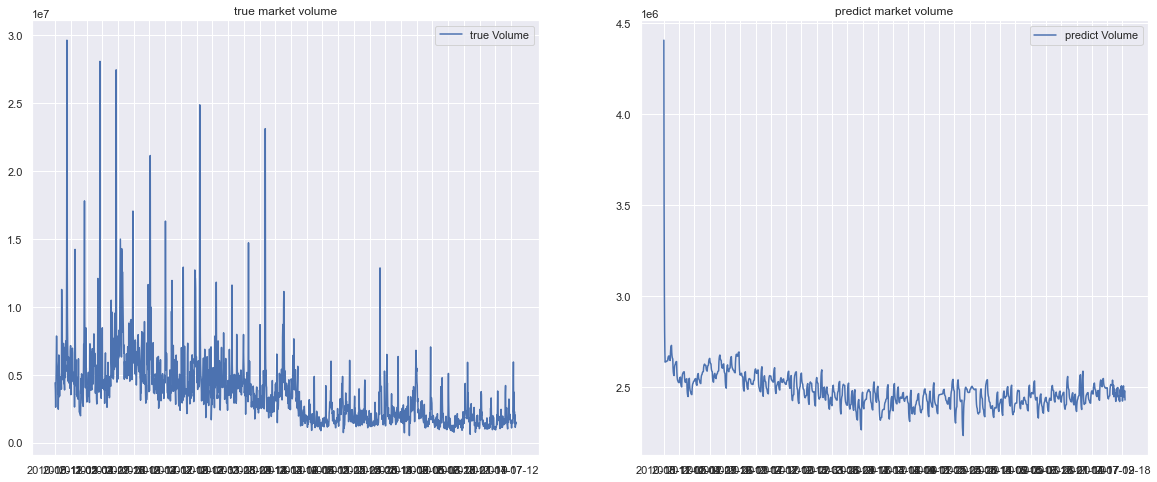

In [15]:
fig = plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(x_range_original, df.iloc[:, -1], label = 'true Volume')
plt.xticks(x_range_original[::60], df.iloc[:, 0].tolist()[::60])
plt.legend()
plt.title('true market volume')
plt.subplot(1, 2, 2)
plt.plot(x_range_future, anchor(df_log[:, -1], 0.5), label = 'predict Volume')
plt.xticks(x_range_future[::60], date_ori[::60])
plt.legend()
plt.title('predict market volume')
plt.show()